# Using Rasterio library for detecting vegetation loss for a wildfire event in Andalusia, Spain

In July 2017, a wildfire event was recorded in Andalusia region of Spain causing a major damage to vegetation and wildlife in the region. The Copernicus Emergency Management Service (CEMS) was then activated to assess the damage caused by the wildfire in the region [(refer)](https://emergency.copernicus.eu/mapping/list-of-components/EMSR237). 

In this notebook, I explore rasterio library to read GeoTIFF files based on Sentinel-2 bands, calculate NDVI layers for two timestamps, and finally, calculate potential vegetation loss due to the wildfire. The final step should give an understanding of the spatial extent in which the vegetation loss was observed. I compare the results with those showcased on the CEMS.

### Step 1: Importing libraries and loading the raster files

In [74]:
# Importing the necessary libraries
import rasterio
import numpy as np
from rasterio.plot import show
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Data dir
data_dir = "data"

# Creating filepaths for the GeoTIFF files from before and after the event
fp = os.path.join(data_dir, "20170701T111051.tif")
fp2 = os.path.join(data_dir, "20181029T111149.tif")

# Open the raster files in read mode
raster_before = rasterio.open(fp)
raster_after = rasterio.open(fp2)

### Step 2: Reading the specific NIR and Red bands from the rasters and visualising

1095.540927711139
1905.1318713665464
<class 'numpy.ndarray'>


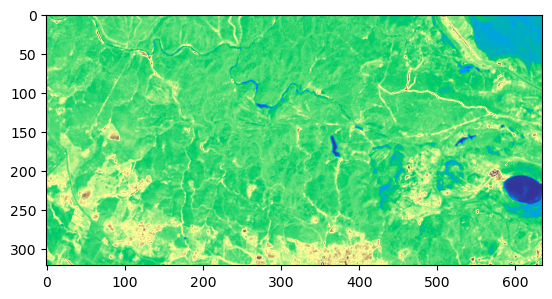

<Axes: >

In [19]:
# Read red channel (channel number 3)
red = raster_before.read(3)
# Read NIR channel (channel number 4)
nir = raster_before.read(4)

# Calculate some stats to check the data
print(red.mean())
print(nir.mean())
print(type(nir))

# Visualize
show(nir, cmap='terrain')

839.9270978978095
1414.0557264454092
<class 'numpy.ndarray'>


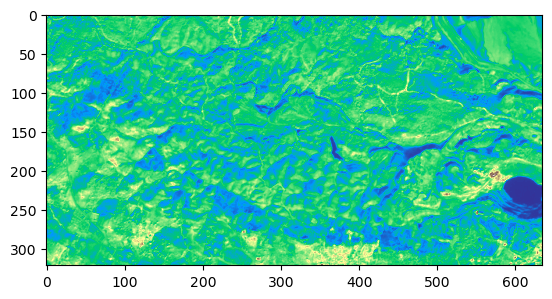

<Axes: >

In [20]:
# Read red channel (channel number 3)
red_after = raster_after.read(3)
# Read NIR channel (channel number 4)
nir_after = raster_after.read(4)

# Calculate some stats to check the data
print(red_after.mean())
print(nir_after.mean())
print(type(nir_after))

# Visualize
show(nir_after, cmap='terrain')

### Code blocks without correcting for datatype

In [23]:
nir
# Important to note that the raster cell values are integers

array([[2042, 2273, 2229, ..., 1180, 1188, 1159],
       [1967, 2174, 2264, ..., 1188, 1186, 1173],
       [1866, 2011, 2198, ..., 1192, 1171, 1161],
       ...,
       [1512, 1510, 1518, ..., 1987, 1951, 2097],
       [1510, 1550, 1581, ..., 2023, 1985, 2144],
       [1505, 1568, 1577, ..., 2143, 2161, 2530]], dtype=uint16)

In [21]:
# Calculate NDVI for one of the rasters to test the results
ndvi_before = (nir-red)/(nir+red)
ndvi_before
# Important to note that some values are over 0 but NDVI can never be zero. This behavior could potentially be because
# of integer operations and division by zero

array([[ 0.5376506 ,  0.61492007,  0.56201822, ..., 26.45491306,
        26.30679534, 26.63910387],
       [ 0.49071618,  0.57707653,  0.5490934 , ..., 26.20833333,
        26.30518697, 26.53833671],
       [ 0.47919144,  0.52060491,  0.53117381, ..., 26.05976096,
        26.45873786, 26.70845243],
       ...,
       [ 0.34101996,  0.35244066,  0.34514843, ...,  0.31328486,
         0.31913455,  0.27438469],
       [ 0.35183527,  0.36084284,  0.35649936, ...,  0.33531353,
         0.34621906,  0.32468335],
       [ 0.35220126,  0.34650064,  0.34212766, ...,  0.32693498,
         0.31969466,  0.22222222]])

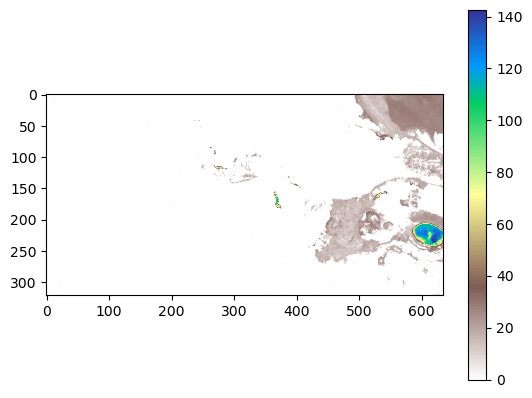

In [22]:
%matplotlib inline
# Plot the NDVI
plt.imshow(ndvi_before, cmap='terrain_r')
# Add colorbar to show the index
plt.colorbar()

# The image shows that NDVI varies from 0 to all the way to 140 showing some unexpected behavior 

### Step 3: Correcting for datatype and division by 0 errors

In [35]:
# Setting float type for the bands' numpy arrays in order to allow for numpy division operation
red = red.astype('f4')
nir = nir.astype('f4')

red_after = red_after.astype('f4')
nir_after = nir_after.astype('f4')

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [36]:
nir
# Note decimal values in the cell values

array([[2042., 2273., 2229., ..., 1180., 1188., 1159.],
       [1967., 2174., 2264., ..., 1188., 1186., 1173.],
       [1866., 2011., 2198., ..., 1192., 1171., 1161.],
       ...,
       [1512., 1510., 1518., ..., 1987., 1951., 2097.],
       [1510., 1550., 1581., ..., 2023., 1985., 2144.],
       [1505., 1568., 1577., ..., 2143., 2161., 2530.]], dtype=float32)

### Step 3: Calculate NDVI for rasters before and after the wildfire

In [37]:
ndvi_before = (nir-red)/(nir+red)
ndvi_after = (nir_after-red_after)/(nir_after+red_after)

In [38]:
ndvi_before
# notice that values that were showing >1 in previous arrays are now between -1 and 1

array([[ 0.5376506 ,  0.6149201 ,  0.5620182 , ..., -0.04569349,
        -0.04463209, -0.05580448],
       [ 0.4907162 ,  0.57707655,  0.5490934 , ..., -0.04807692,
        -0.04624045, -0.04827586],
       [ 0.47919145,  0.5206049 ,  0.5311738 , ..., -0.0501992 ,
        -0.052589  , -0.0518579 ],
       ...,
       [ 0.34101996,  0.35244066,  0.3451484 , ...,  0.31328487,
         0.31913456,  0.27438468],
       [ 0.35183528,  0.36084285,  0.35649934, ...,  0.33531353,
         0.34621906,  0.32468334],
       [ 0.35220125,  0.34650064,  0.34212765, ...,  0.326935  ,
         0.31969467,  0.22222222]], dtype=float32)

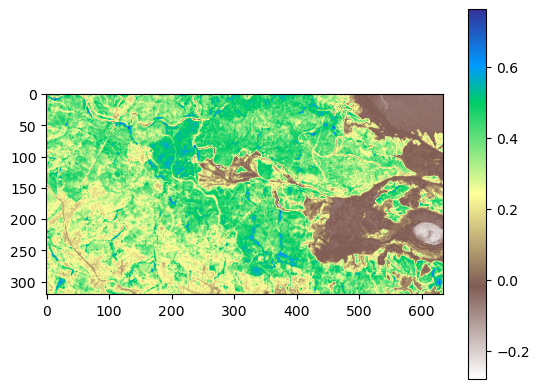

In [39]:
%matplotlib inline
# Plot the NDVI
plt.imshow(ndvi_before, cmap='terrain_r')
# Add colorbar to show the index
plt.colorbar()

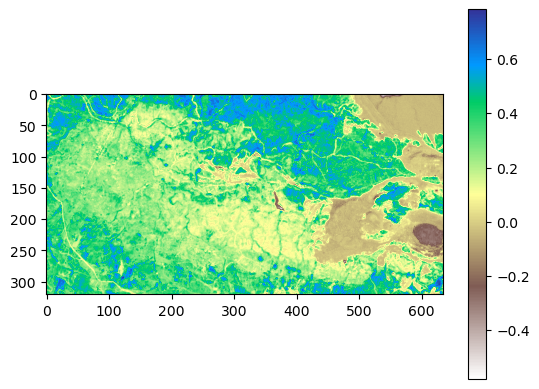

In [40]:
%matplotlib inline
# Plot the NDVI
plt.imshow(ndvi_after, cmap='terrain_r')
# Add colorbar to show the index
plt.colorbar()

### Step 4: Calculating NDVI difference between before and after the event

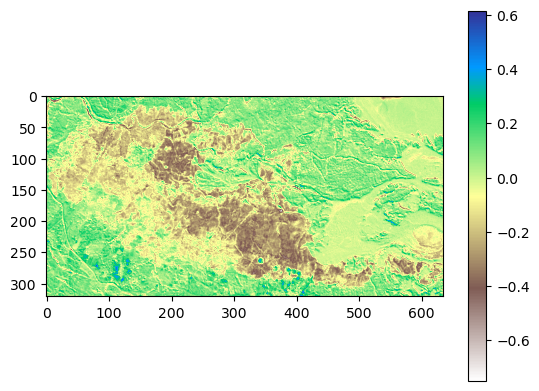

In [42]:
ndvi_change = ndvi_after - ndvi_before

%matplotlib inline
# Plot the NDVI change
plt.imshow(ndvi_change, cmap='terrain_r')
# Add colorbar to show the difference
plt.colorbar()

### Step 5: Comparing with Copernicus Emergency service area deliantion
Source: [Damaged Area Rapid Mapping](https://emergency.copernicus.eu/mapping/system/files/components/EMSN060_01ANDALUSIA_P1-6-FIRESEVERITY-NDVI_OVERVIEWA2_v1_300dpi.pdf)

It can be visually noted that the brown area in the previous map coincides with the damaged area delineated by the Emergency service.

In [72]:
import folium
import requests
import geopandas as gpd

damaged_area = 'data/damaged_aoi_.geojson'
damaged_area

m = folium.Map(location = [37.70803, -6.64465], zoom_start = 13, control_scale=True)

folium.GeoJson(damaged_area).add_to(m)
m

## References
1. European Union, 1995-2023. (n.d.). COPERNICUS EMERGENCY MANAGEMENT SERVICE | Copernicus EMS - Mapping. Copernicus EMS - Mapping. https://emergency.copernicus.eu/mapping/list-of-components/EMSR237
2. Henrikki Tenkanen & Vuokko Heikinheimo, Department of Geosciences and Geography, University of Helsinki. Last updated on Sep 17, 2021. https://autogis-site.readthedocs.io/en/2020_/notebooks/Raster/raster-map-algebra.html